# Project: TMDB Movie Recommendations system


Virtually everyone had an online experience where a website makes personalized recommendations in hopes of future sales or ongoing traffic. Amazon tells you “Customers Who Bought This Item Also Bought”, Udemy tells you “Students Who Viewed This Course Also Viewed”. And Netflix awarded a $1 million prize to a developer team in 2009, for an algorithm that increased the accuracy of the company’s recommendation system by 10 percent.



### Data Source
##### Link: https://www.kaggle.com/tmdb/tmdb-movie-metadata
##### Link: https://www.kaggle.com/rounakbanik/the-movies-dataset

In [1]:
# import packages

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
from scipy.sparse import csr_matrix
import pandas as pd 
import numpy as np 
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from surprise.accuracy import mse, mae
from surprise.model_selection import cross_validate
from surprise import Reader, Dataset, SVD 
from collections import defaultdict
import missingno as msno

In [2]:
# getting the data
df_credits=pd.read_csv('tmdb_5000_credits.csv')
df_movies=pd.read_csv('tmdb_5000_movies.csv')

In [3]:
df_credits.shape

(4803, 4)

In [4]:
df_movies.shape

(4803, 20)

In [5]:
# checking for null values
df_credits.isnull().sum()

movie_id    0
title       0
cast        0
crew        0
dtype: int64

In [6]:
df_movies.isnull().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

In [7]:
df_movies

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
5,258000000,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""na...",http://www.sonypictures.com/movies/spider-man3/,559,"[{""id"": 851, ""name"": ""dual identity""}, {""id"": ...",en,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,115.699814,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-01,890871626,139.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,The battle within.,Spider-Man 3,5.9,3576
6,260000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...",http://disney.go.com/disneypictures/tangled/,38757,"[{""id"": 1562, ""name"": ""hostage""}, {""id"": 2343,...",en,Tangled,When the kingdom's most wanted-and most charmi...,48.681969,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2010-11-24,591794936,100.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,They're taking adventure to new lengths.,Tangled,7.4,3330
7,280000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://marvel.com/movies/movie/193/avenge

In [8]:
df_credits

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
5,559,Spider-Man 3,"[{""cast_id"": 30, ""character"": ""Peter Parker / ...","[{""credit_id"": ""52fe4252c3a36847f80151a5"", ""de..."
6,38757,Tangled,"[{""cast_id"": 34, ""character"": ""Flynn Rider (vo...","[{""credit_id"": ""52fe46db9251416c91062101"", ""de..."
7,99861,Avengers: Age of Ultron,"[{""cast_id"": 76, ""character"": ""Tony Stark / Ir...","[{""credit_id"": ""55d5f7d4c3a3683e7e0016eb"", ""de..."
8,767,Harry Potter and the Half-Blood Prince,"[{""cast_id"": 3, ""character"": ""Harry Potter"", ""...","[{""credit_id"": ""52fe4273c3a36847f801fab1"", ""de..."
9,209112,Batman v Superman: Dawn of Justice,"[{""cast_id"": 18, ""character"": ""Bruce Wayne / B...","[{""credit_id"": ""553bf23692514135c8002886"", ""de..."


In [9]:
# renaming the id calumn name as movie_id so that we can merge the columns on movie_id
df_movies.rename(columns={'id': 'movie_id'},inplace = True)

In [10]:
df_movies.shape

(4803, 20)

In [11]:
# merging the two data sets
df= df_movies.merge(df_credits,on='movie_id')

In [12]:
#printing the data shape
df.shape

(4803, 23)

In [13]:
# getting the null values sum on mergres data
df.isnull().sum()

budget                     0
genres                     0
homepage                3091
movie_id                   0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title_x                    0
vote_average               0
vote_count                 0
title_y                    0
cast                       0
crew                       0
dtype: int64

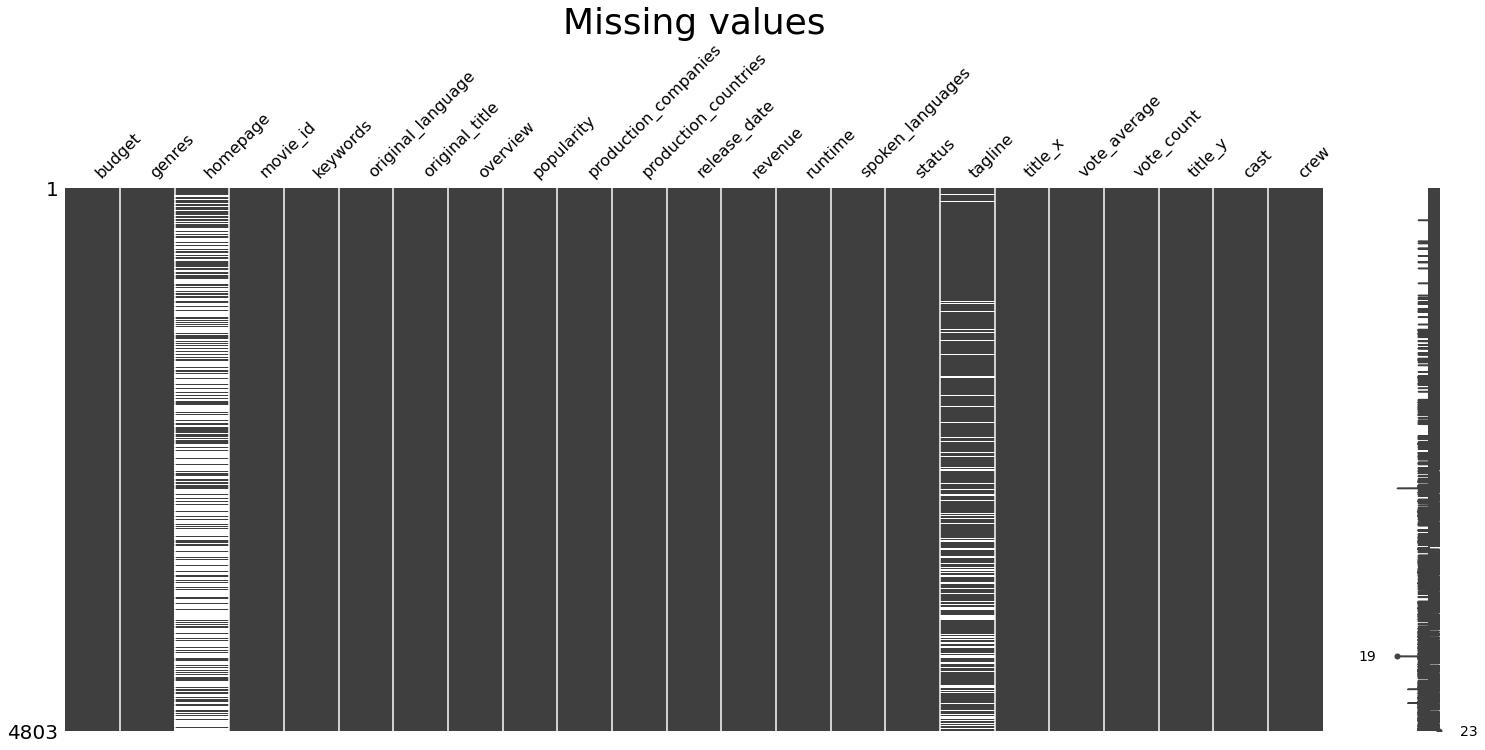

In [14]:
#plotting the null values
msno.matrix(df) ;
plt.title("Missing values",color='Black', fontsize=36);

In [15]:
df.isnull().sum()

budget                     0
genres                     0
homepage                3091
movie_id                   0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title_x                    0
vote_average               0
vote_count                 0
title_y                    0
cast                       0
crew                       0
dtype: int64

In [16]:

df.dtypes

budget                    int64
genres                   object
homepage                 object
movie_id                  int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title_x                  object
vote_average            float64
vote_count                int64
title_y                  object
cast                     object
crew                     object
dtype: object

In [17]:
df.describe()

,budget,movie_id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 23 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
homepage                1712 non-null object
movie_id                4803 non-null int64
keywords                4803 non-null object
original_language       4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title_x                 4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null 

In [19]:
df.duplicated().sum()

0

In [20]:
# converting the json data to list

from ast import literal_eval
# Returns the list top l elements or entire list; whichever is more.
def get_list(x, l=5):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than l elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > l:
            names = names[:l]
        return names

    #Return empty list in case of missing/malformed data
    return []

df['genres'] = df['genres'].apply(literal_eval)
df['genres'] = df['genres'].apply(get_list)
df['keywords'] = df['keywords'].apply(literal_eval)
df['keywords'] = df['keywords'].apply(get_list)

In [21]:
df

,budget,genres,homepage,movie_id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, based on novel, secret agent, sequel, mi6]",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[Action, Crime, Drama, Thriller]",http://www.thedarkknightrises.com/,49026,"[dc comics, crime fighter, terrorist, secret i...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[Action, Adventure, Science Fiction]",http://movies.disney.com/john-carter,49529,"[based on novel, mars, medallion, space travel...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
5,258000000,"[Fantasy, Action, Adventure]",http://www.sonypictures.com/movies/spider-man3/,559,"[dual identity, amnesia, sandstorm, love of on...",en,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,115.699814,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,139.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,The battle within.,Spider-Man 3,5.9,3576,Spider-Man 3,"[{""cast_id"": 30, ""character"": ""Peter Parker / ...","[{""credit_id"": ""52fe4252c3a36847f80151a5"", ""de..."
6,260000000,"[Animation, Family]",http://disney.go.com/disneypictures/tangled/,38757,"[hostage, magic, horse, fairy tale, musical]",en,Tangled,When the kingdom's most wanted-and most charmi...,48.681969,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,100.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,They're taking adventure to new lengths.,Tangled,7.4,3330,Tangled,"[{""cast_id"": 34, ""character"": ""Flynn Rider (vo...","[{""credit_id"": ""52fe46db9251416c91062101"", ""de..."
7

In [22]:
df = df.drop(columns = ["homepage","tagline"],axis = 1)
df = df.dropna(axis = 0)

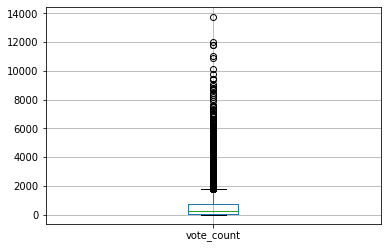

In [23]:
df.boxplot(column=["vote_count"])

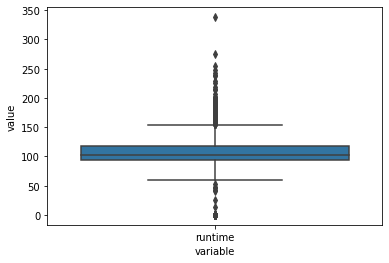

In [24]:
sns.boxplot(x="variable", y="value", data=pd.melt(df[["runtime"]]))
plt.show()

### How many Number of movies released in each year ?

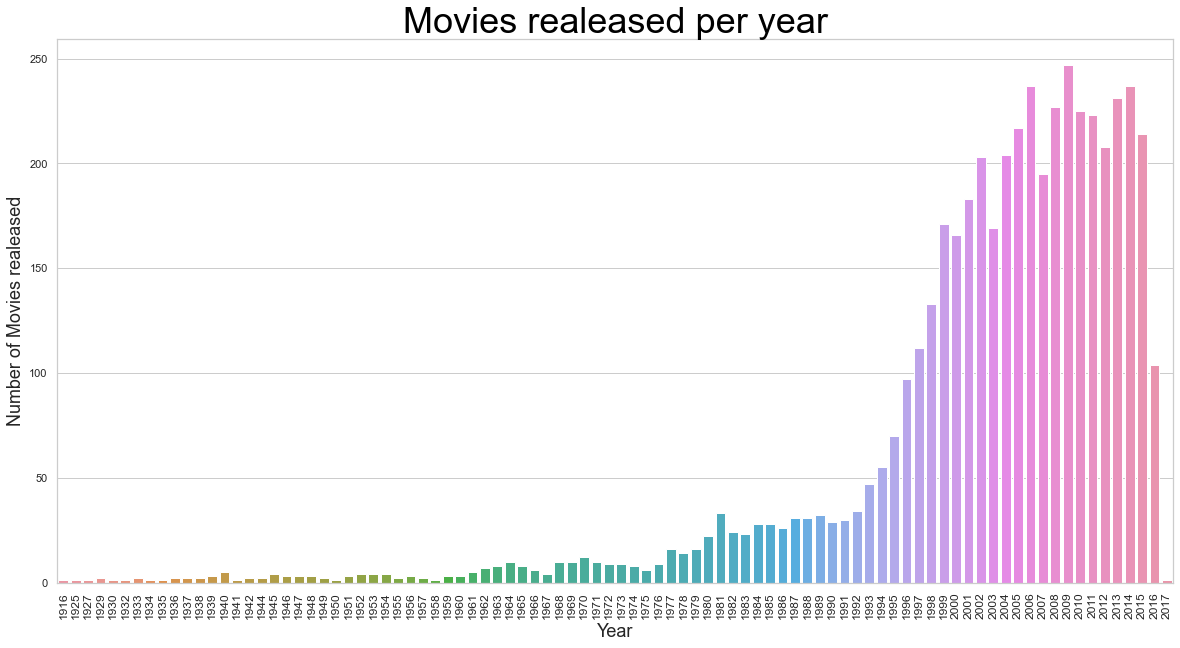

In [25]:
# bar plot using Seaborn to plot the number of movies released in each year
df = df[df.release_date.notnull()]
import math
plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
#Extracting year data from column from release_data column
sns.countplot((pd.DatetimeIndex(df['release_date']).year).astype(int))
plt.xticks(rotation=90,fontsize=12)
plt.ylabel("Number of Movies realeased",fontsize=18)
plt.xlabel("Year",fontsize=18)
plt.title("Movies realeased per year",color='Black', fontsize=36)

plt.show()

In [26]:
# converting the list values into column values and dulipate
def lateral_explode(dataframe, fieldname): 
    temp_fieldname = fieldname + '_made_tuple_' 
    dataframe[temp_fieldname] = dataframe[fieldname].apply(tuple)       
    list_of_dataframes = []
    for values in dataframe[temp_fieldname].unique().tolist(): 
        list_of_dataframes.append(pd.DataFrame({
            temp_fieldname: [values] * len(values), 
            fieldname: list(values), 
        }))
    dataframe = dataframe[list(set(dataframe.columns) - set([fieldname]))].merge(pd.concat(list_of_dataframes), how='left', on=temp_fieldname) 
    del dataframe[temp_fieldname]

    return dataframe

new_df = lateral_explode(df,"genres")

In [27]:
new_df = lateral_explode(new_df,"keywords")

### How many number of Movies based on GENERS ?

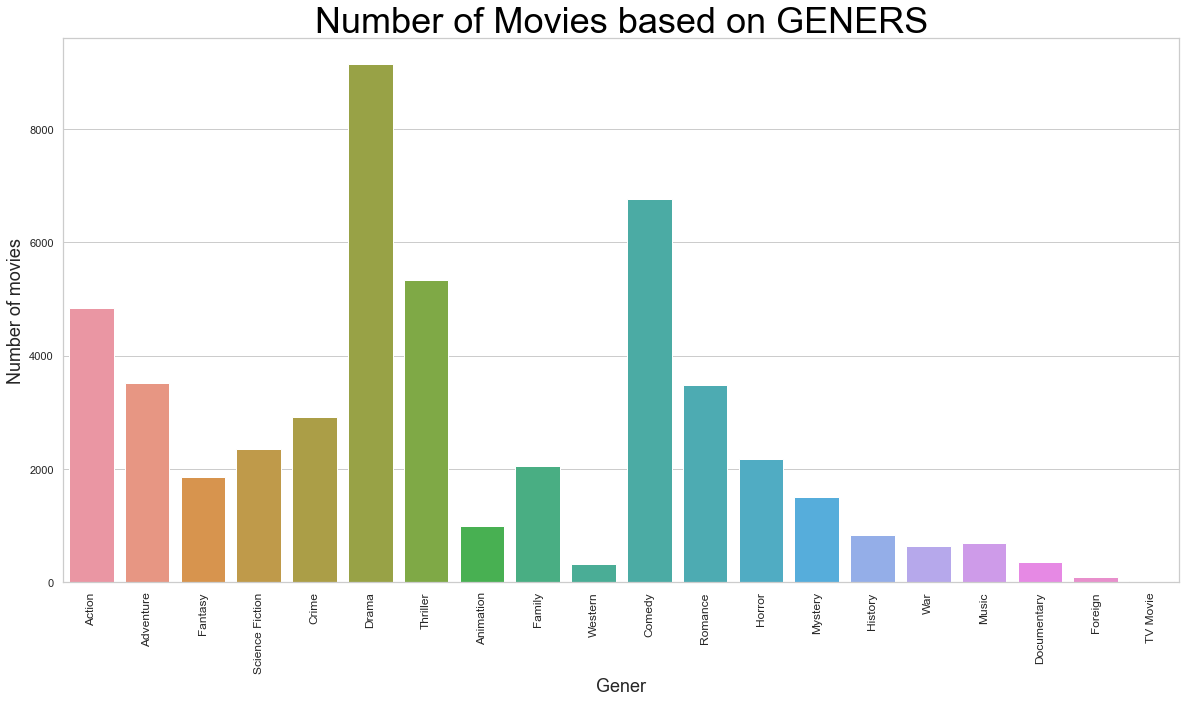

In [28]:
plt.figure(figsize=(20,10))
sns.countplot(new_df["genres"])
sns.set(style="whitegrid")
plt.xticks(rotation=90,fontsize=12)
plt.ylabel("Number of movies",fontsize=18)
plt.xlabel("Gener",fontsize=18)
plt.title("Number of Movies based on GENERS",color='Black', fontsize=36)

plt.show()

### Which are the most genres ?

(-0.5, 999.5, 399.5, -0.5)

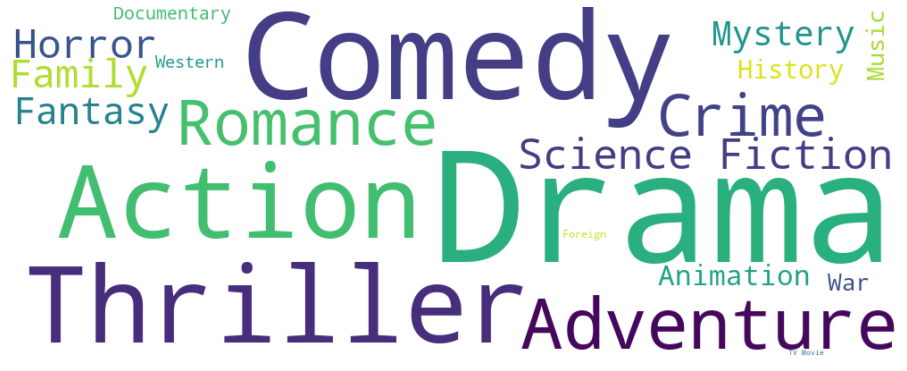

In [29]:
genre_wc = WordCloud(width=1000,height=400,background_color='white')
genre_wc.generate_from_frequencies(new_df["genres"].value_counts().to_dict())
plt.figure(figsize=(16, 8))
#plt.title("GENERS",color='Black', fontsize=36)
plt.imshow(genre_wc, interpolation="bilinear")
plt.axis('off')

In [30]:
new_df["genres"].value_counts()

Drama              9142
Comedy             6767
Thriller           5338
Action             4841
Adventure          3513
Romance            3485
Crime              2923
Science Fiction    2347
Horror             2169
Family             2051
Fantasy            1863
Mystery            1495
Animation           982
History             825
Music               695
War                 630
Documentary         350
Western             312
Foreign              85
TV Movie             23
Name: genres, dtype: int64

### Which are the most keywords ?

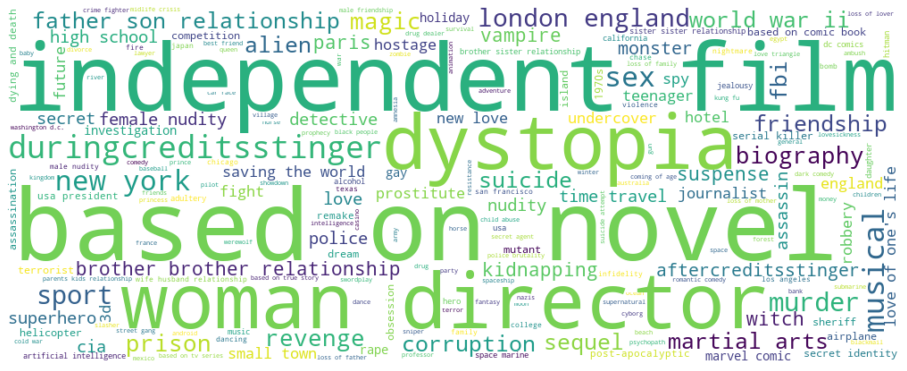

In [31]:
genre_wc = WordCloud(width=1000,height=400,background_color='white')
genre_wc.generate_from_frequencies(new_df["keywords"].value_counts().to_dict())
plt.figure(figsize=(16, 8))
plt.imshow(genre_wc, interpolation="bilinear")
plt.axis('off');

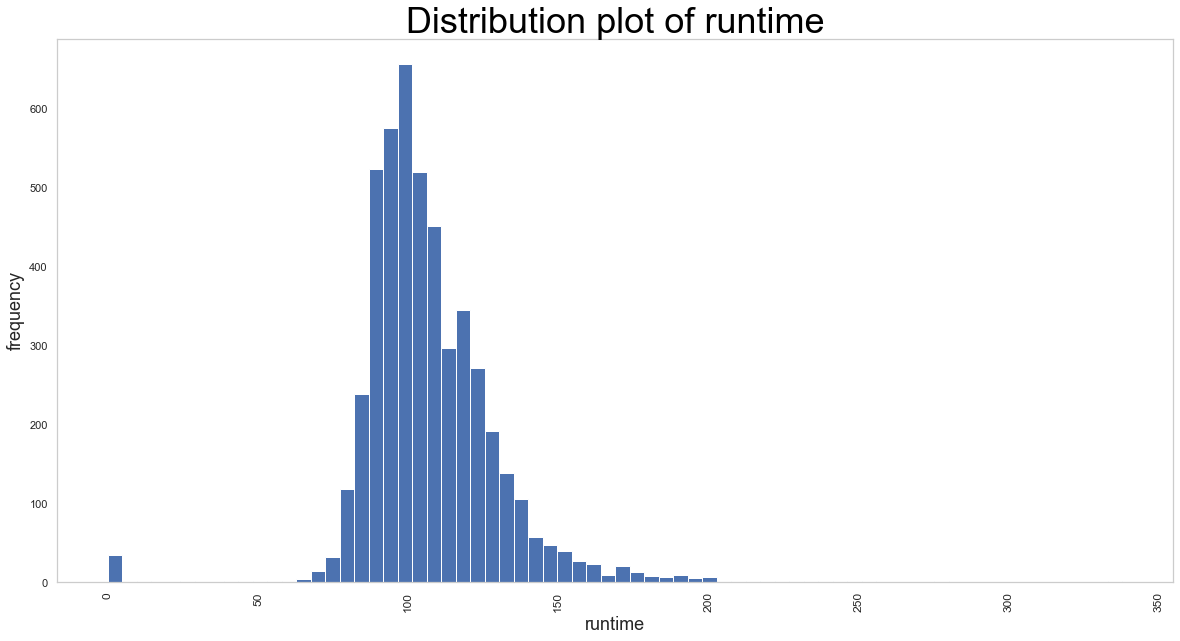

In [32]:
plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
plt.hist(df["runtime"],bins =70)
plt.xticks(rotation=90,fontsize=12)
plt.ylabel("frequency",fontsize=18)
plt.xlabel("runtime",fontsize=18)
plt.title("Distribution plot of runtime",color='Black', fontsize=36)
plt.grid()
plt.show()

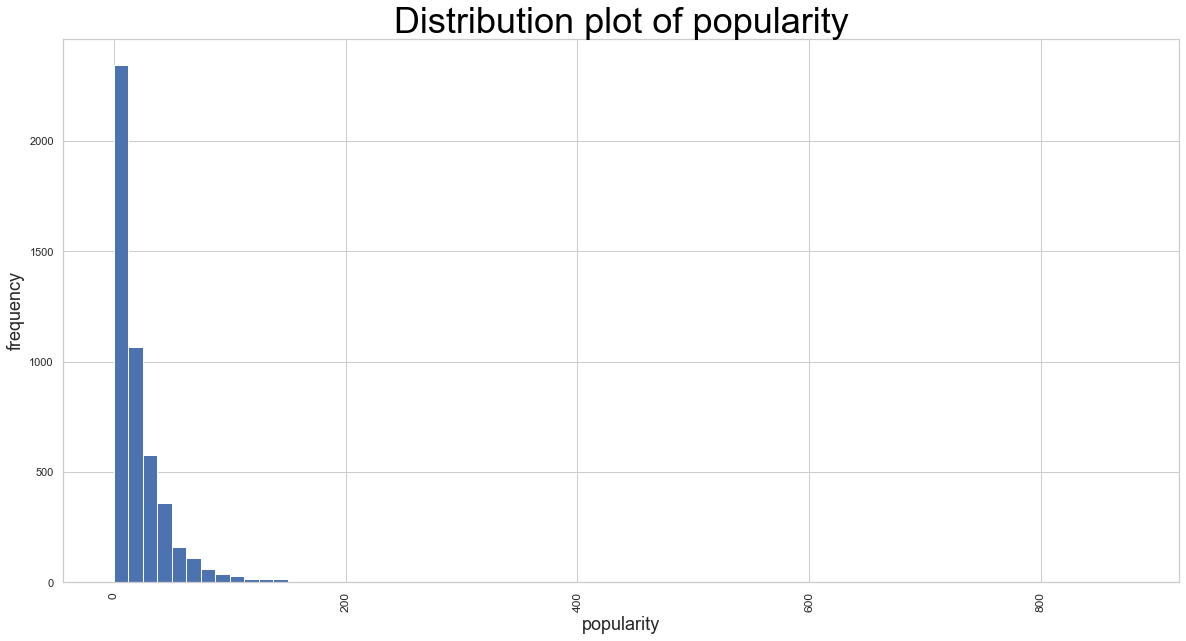

In [33]:
plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
plt.hist(df["popularity"],bins =70)
plt.xticks(rotation=90,fontsize=12)
plt.ylabel("frequency",fontsize=18)
plt.xlabel("popularity",fontsize=18)
plt.title("Distribution plot of popularity",color='Black', fontsize=36)
plt.show()

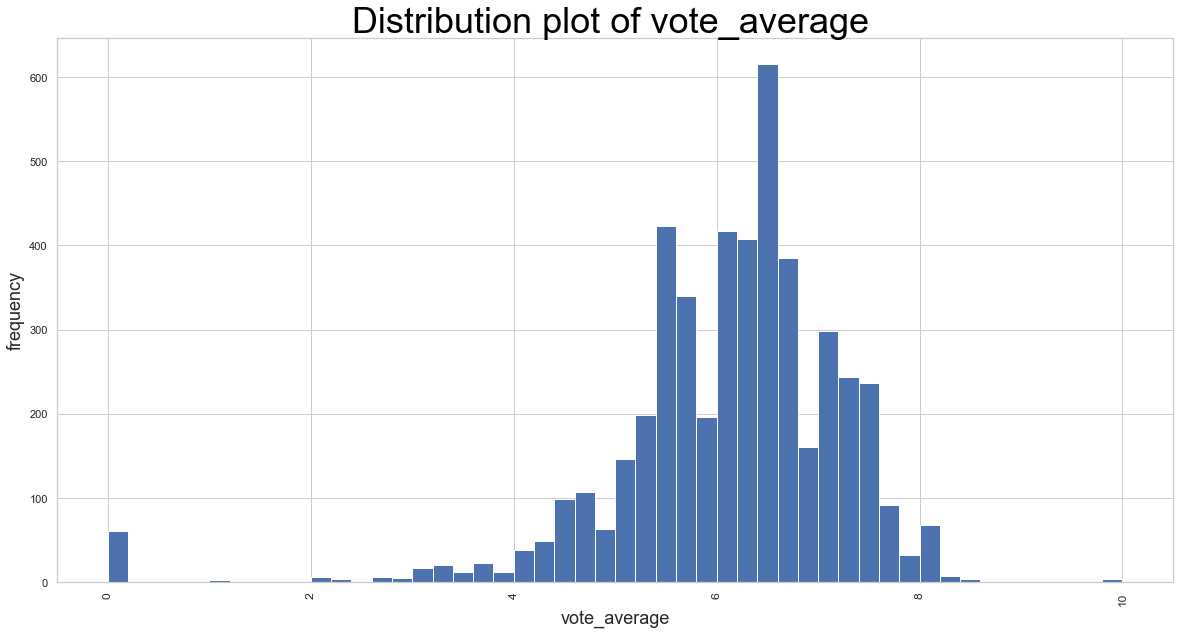

In [34]:
plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
plt.hist(df["vote_average"],bins = 50)
plt.xticks(rotation=90,fontsize=12)
plt.ylabel("frequency",fontsize=18)
plt.xlabel("vote_average",fontsize=18)
plt.title("Distribution plot of vote_average ",color='Black', fontsize=36)
plt.show()

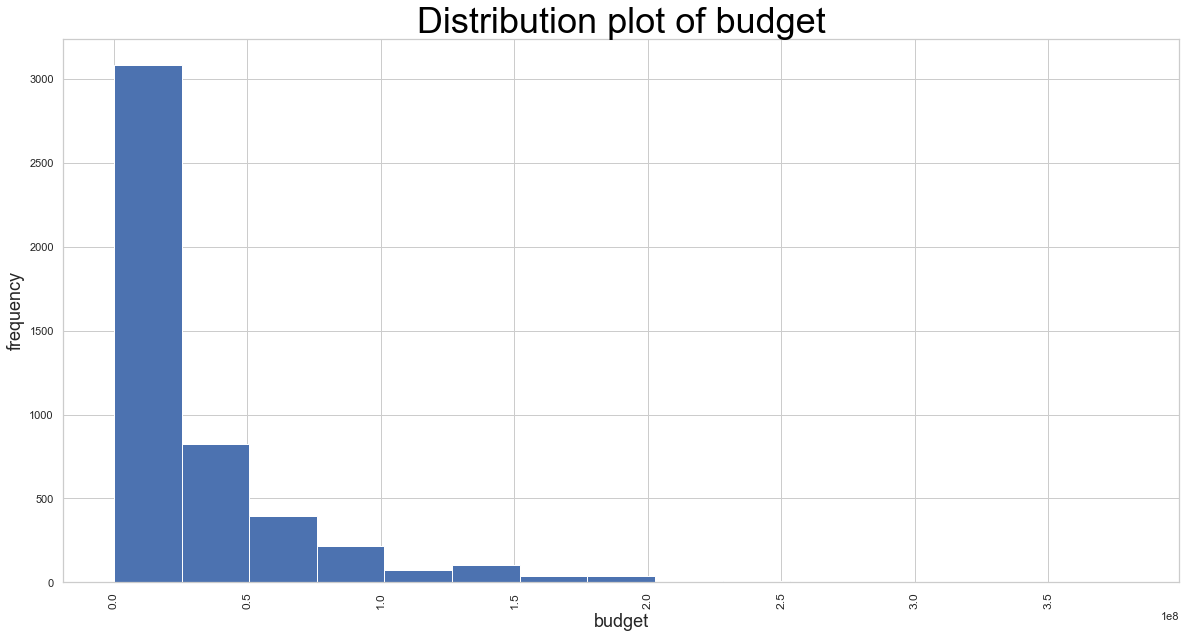

In [35]:
plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
plt.hist(df["budget"],bins = 15)
plt.xticks(rotation=90,fontsize=12)
plt.ylabel("frequency",fontsize=18)
plt.xlabel("budget",fontsize=18)
plt.title("Distribution plot of budget",color='Black', fontsize=36)
plt.show()

### Calculating IMDB weighted Average 

Link: https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV#

Reference Link: https://tutorialedge.net/python/building-imdb-top-250-clone-pandas/

The metric is the numeric quantity based on which you rank movies. A movie is considered to be better than another movie if it has a higher metric score than the other movie. It is very important that you have a robust and reliable metric to build your chart upon to ensure a good quality of recommendations.

The choice of a metric is arbitrary. One of the simplest metrics that can be used is the movie rating. However, this suffers from a variety of disadvantages. In the first place, the movie rating does not take the popularity of a movie into consideration. Therefore, a movie rated 9 by 100,000 users will be placed below a movie rated 9.5 by 100 users. This is not desirable as it is highly likely that a movie watched and rated only by 100 people caters to a very specific niche and may not appeal as much to the average person as the former.

It is also a well-known fact that as the number of voters increase, the rating of a movie normalizes and it approaches a value that is reflective of the movie’s quality and popularity with the general populace. To put it another way, movies with very few ratings are not very reliable. A movie rated 10/10 by five users doesn’t necessarily mean that it’s a good movie.

Therefore, what you need is a metric that can, to an extent, take into account the movie rating and the number of votes it has garnered (a proxy for popularity). This would give a greater preference to a blockbuster movie rated 8 by 100,000 users over an art house movie rated 9 by 100 users.

Fortunately, you do not have to brainstorm a mathematical formula for the metric. You can use IMDB’s weighted rating formula as your metric. Mathematically, it can be represented as follows:



Weighted Rating (WR) =  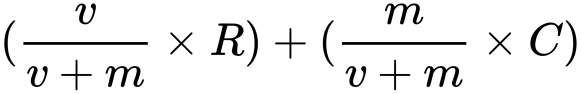



The following apply:

- v is the number of votes garnered by the movie.
- m is the minimum number of votes required for the movie to be in the chart (the prerequisite)
- R is the mean rating of the movie
- C is the mean rating of all the movies in the dataset
- You already have the values for v and R for every movie in the form of the vote_count and vote_average features respectively. Calculating C is extremely trivial.



In [36]:
df

,budget,genres,movie_id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,...,runtime,spoken_languages,status,title_x,vote_average,vote_count,title_y,cast,crew,genres_made_tuple_
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...","(Action, Adventure, Fantasy, Science Fiction)"
1,300000000,"[Adventure, Fantasy, Action]",285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...","(Adventure, Fantasy, Action)"
2,245000000,"[Action, Adventure, Crime]",206647,"[spy, based on novel, secret agent, sequel, mi6]",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...","(Action, Adventure, Crime)"
3,250000000,"[Action, Crime, Drama, Thriller]",49026,"[dc comics, crime fighter, terrorist, secret i...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...","(Action, Crime, Drama, Thriller)"
4,260000000,"[Action, Adventure, Science Fiction]",49529,"[based on novel, mars, medallion, space travel...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...","(Action, Adventure, Science Fiction)"
5,258000000,"[Fantasy, Action, Adventure]",559,"[dual identity, amnesia, sandstorm, love of on...",en,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,115.699814,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,139.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Spider-Man 3,5.9,3576,Spider-Man 3,"[{""cast_id"": 30, ""character"": ""Peter Parker / ...","[{""credit_id"": ""52fe4252c3a36847f80151a5"", ""de...","(Fantasy, Action, Adventure)"
6,260000000,"[Animation, Family]",38757,"[hostage, magic, horse, fairy tale, musical]",en,Tangled,When the kingdom's most wanted-and most charmi...,48.681969,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",...,100.0,"[{""iso_639_1"": ""en"", ""name"": ""English"

In [37]:
m = df['vote_count'].quantile(0.80)
m

958.4000000000001

In [38]:
#Only consider movies longer than 45 minutes and shorter than 300 minutes
IMDBlist = df[(df['runtime'] >= 45) & (df['runtime'] <= 300)]

#Only consider movies that have garnered more than m votes
IMDBlist = IMDBlist[IMDBlist['vote_count'] >= m]

#Inspect the number of movies that made the cut
IMDBlist.shape

(960, 22)

In [39]:
C = df['vote_average'].mean()
C

6.094186288810164

In [40]:
v = IMDBlist['vote_count']
R = IMDBlist['vote_average']
## Compute the weighted score
IMDBlist['IMDB'] = (v/(v+m) * R) + (m/(m+v) * C)

In [41]:
IMDBlist[["original_title","IMDB"]][:11]

,original_title,IMDB
0,Avatar,7.116932
1,Pirates of the Caribbean: At World's End,6.758513
2,Spectre,6.263636
3,The Dark Knight Rises,7.456606
4,John Carter,6.098192
5,Spider-Man 3,5.941044
6,Tangled,7.108168
7,Avengers: Age of Ultron,7.150409
8,Harry Potter and the Half-Blood Prince,7.199806
9,Batman v Superman: Dawn of Justice,5.747447


In [42]:
print("Top 10 Movies Based on IMDB Rating\n")
listName = list(IMDBlist.sort_values(by=['IMDB'], ascending = False).head(15).original_title)
for i in range(len(listName)):
    print("{:2d} - {:s}".format(i+1, listName[i]))

Top 10 Movies Based on IMDB Rating

 1 - The Shawshank Redemption
 2 - Fight Club
 3 - The Godfather
 4 - Pulp Fiction
 5 - The Dark Knight
 6 - Forrest Gump
 7 - Inception
 8 - Interstellar
 9 - The Empire Strikes Back
10 - Schindler's List
11 - Whiplash
12 - The Lord of the Rings: The Return of the King
13 - 千と千尋の神隠し
14 - Star Wars
15 - Se7en


# Building a content based recommender on geners, overview 

Reference: https://towardsdatascience.com/content-based-recommender-systems-28a1dbd858f5


we willbebuilding recommender based on the movie genres and overiew. A fairly common approach for this problem is to use a tf-idf vectorizer.
While this approach is more commonly used on a text corpus, it possesses some interesting properties that will be useful in order to obtain a vector representation of the data. The expression is defined as follows:

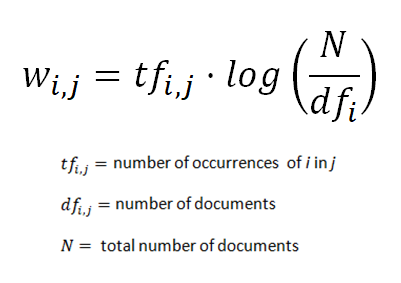


Here we have the product of the term frequency, i.e. the amount of times a given term (genre) occurs in a document (genres of a movie), times the right side term, which basically scales the term frequency depending on the amount of times a given term appears in all documents (movies).
The fewer movies that contain a given genre (df_i), the higher the resulting weight. The logarithm is basically there to smooth the result of the division, i.e. avoids huge differences as a result of the right hand term.

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

def get_recommendations_by_overview(title):
# instantiate the vectorizer object
    tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
    
#     df['overview'] = df['overview'].fillna('')
# fitting using vectorizer over overview column
    tfidf_matrix = tf.fit_transform(df['overview']);
#getting the cosine similarity
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
#removing the duplicates from the original columns
    indices = pd.Series(df.index, index=df['original_title']).drop_duplicates();
#getting the indices of the title
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return print(df['original_title'].iloc[movie_indices]);

def get_recommendations_by_geners(title):
# instantiate the vectorizer object
    tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
#     df['overview'] = df['overview'].fillna('')
# fitting using vectorizer over overview column
    new_df["genres"] = new_df["genres"].fillna('')
    tfidf_matrix = tf.fit_transform(new_df["genres"])
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
#removing the duplicates from the original columns
    indices = pd.Series(df.index, index=df['original_title']).drop_duplicates()
#getting the indices of the title
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return print(df['original_title'].iloc[movie_indices])

In [44]:
def get_recommendations_by_overview_mvid(title):
# instantiate the vectorizer object
    tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
    
#     df['overview'] = df['overview'].fillna('')
# fitting using vectorizer over overview column
    tfidf_matrix = tf.fit_transform(df['overview']);
#getting the cosine similarity
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
#removing the duplicates from the original columns
    indices = pd.Series(df.index, index=df['original_title']).drop_duplicates();
#getting the indices of the title
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    #print(movie_indices)
   # print(df['movie_id'].iloc[movie_indices])
    return movie_indices;


In [45]:
get_recommendations_by_overview_mvid('The Dark Knight Rises')

[299, 65, 1359, 428, 2507, 119, 3853, 1181, 210, 4645]

In [46]:
get_recommendations_by_overview('The Dark Knight Rises');

299                              Batman Forever
65                              The Dark Knight
1359                                     Batman
428                              Batman Returns
2507                                  Slow Burn
119                               Batman Begins
3854    Batman: The Dark Knight Returns, Part 2
1181                                        JFK
210                              Batman & Robin
4649                            Shotgun Stories
Name: original_title, dtype: object


In [47]:
get_recommendations_by_geners('The Dark Knight Rises')

1     Pirates of the Caribbean: At World's End
2                                      Spectre
3                        The Dark Knight Rises
4                                  John Carter
30                                Spider-Man 2
31                                  Iron Man 3
32                         Alice in Wonderland
33                       X-Men: The Last Stand
34                         Monsters University
35         Transformers: Revenge of the Fallen
Name: original_title, dtype: object


In [48]:
get_recommendations_by_geners('The Avengers')

16                                    The Avengers
17     Pirates of the Caribbean: On Stranger Tides
18                                  Men in Black 3
19       The Hobbit: The Battle of the Five Armies
80                     Snow White and the Huntsman
81                                      Maleficent
82                  Dawn of the Planet of the Apes
83                                      The Lovers
84                                        47 Ronin
120                    Madagascar: Escape 2 Africa
Name: original_title, dtype: object


In [49]:
get_recommendations_by_overview('The Avengers');

91                      Independence Day: Resurgence
588                  Wall Street: Money Never Sleeps
256                                        Allegiant
4620                            Fighting Tommy Riley
7                            Avengers: Age of Ultron
154                            Rise of the Guardians
1678                                 United Passions
230     Star Wars: Episode II - Attack of the Clones
3824                                  The Full Monty
2136                      Team America: World Police
Name: original_title, dtype: object


# KNN Search 

the kNN algorithm measures distance to determine the “closeness” of instances. It then classifies an instance by finding its nearest neighbors, and picks the most popular class among the neighbors.

In [50]:
#get ratings data from csv files 
df1=pd.read_csv('tmdb_5000_credits.csv')
ratings=pd.read_csv('ratings_small.csv')
ratings.rename(columns={'movieId': 'movie_id'},inplace = True)

# merging the two dataFrames
df_ratings = pd.merge(df1,ratings , on='movie_id')


In [51]:
df_ratings

,movie_id,title,cast,crew,userId,rating,timestamp
0,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",39,4.0,832523436
1,559,Spider-Man 3,"[{""cast_id"": 30, ""character"": ""Peter Parker / ...","[{""credit_id"": ""52fe4252c3a36847f80151a5"", ""de...",492,5.0,898111329
2,767,Harry Potter and the Half-Blood Prince,"[{""cast_id"": 3, ""character"": ""Harry Potter"", ""...","[{""credit_id"": ""52fe4273c3a36847f801fab1"", ""de...",30,4.0,990239999
3,58,Pirates of the Caribbean: Dead Man's Chest,"[{""cast_id"": 37, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe4211c3a36847f8001873"", ""de...",19,3.0,855190167
4,58,Pirates of the Caribbean: Dead Man's Chest,"[{""cast_id"": 37, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe4211c3a36847f8001873"", ""de...",23,3.5,1148672099
5,58,Pirates of the Caribbean: Dead Man's Chest,"[{""cast_id"": 37, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe4211c3a36847f8001873"", ""de...",28,5.0,938944078
6,58,Pirates of the Caribbean: Dead Man's Chest,"[{""cast_id"": 37, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe4211c3a36847f8001873"", ""de...",36,5.0,847057363
7,58,Pirates of the Caribbean: Dead Man's Chest,"[{""cast_id"": 37, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe4211c3a36847f8001873"", ""de...",63,0.5,1075307034
8,58,Pirates of the Caribbean: Dead Man's Chest,"[{""cast_id"": 37, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe4211c3a36847f8001873"", ""de...",70,5.0,853954401
9,58,Pirates of the Caribbean: Dead Man's Chest,"[{""cast_id"": 37, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe4211c3a36847f8001873"", ""de...",85,1.0,837506990


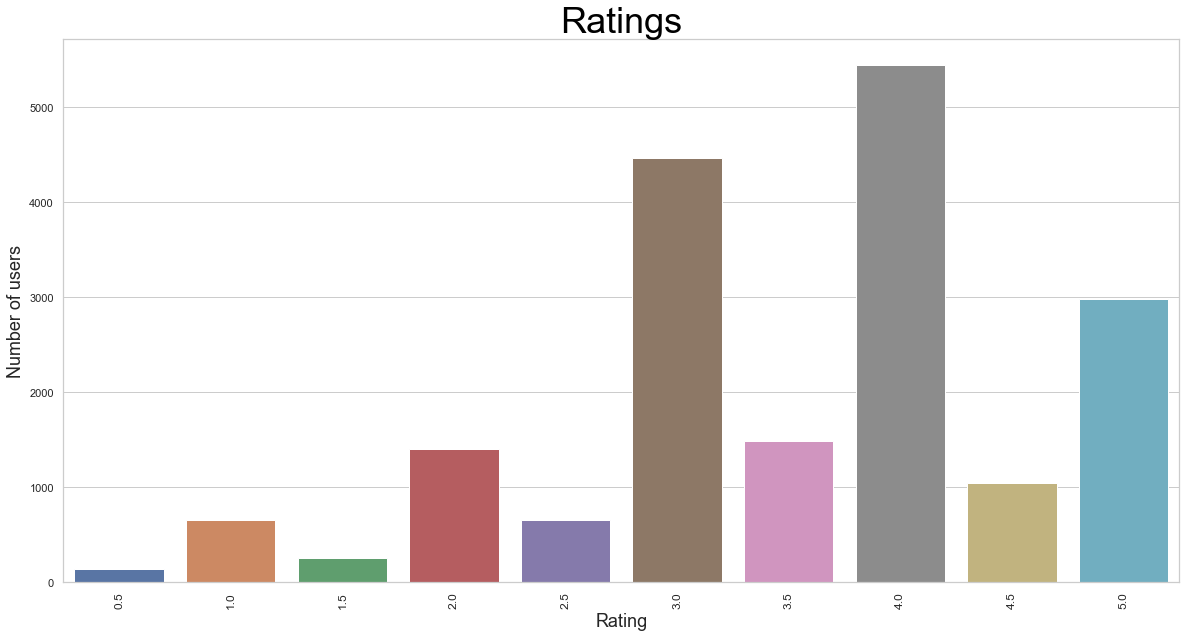

In [52]:

plt.figure(figsize=(20,10))
sns.countplot(df_ratings["rating"])
sns.set(style="whitegrid")
plt.xticks(rotation=90,fontsize=12)
plt.ylabel("Number of users",fontsize=18)
plt.xlabel("Rating",fontsize=18)
plt.title("Ratings",color='Black', fontsize=36)
plt.show()

In [53]:
user_rating = df_ratings.copy()

In [54]:
user_rating

,movie_id,title,cast,crew,userId,rating,timestamp
0,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",39,4.0,832523436
1,559,Spider-Man 3,"[{""cast_id"": 30, ""character"": ""Peter Parker / ...","[{""credit_id"": ""52fe4252c3a36847f80151a5"", ""de...",492,5.0,898111329
2,767,Harry Potter and the Half-Blood Prince,"[{""cast_id"": 3, ""character"": ""Harry Potter"", ""...","[{""credit_id"": ""52fe4273c3a36847f801fab1"", ""de...",30,4.0,990239999
3,58,Pirates of the Caribbean: Dead Man's Chest,"[{""cast_id"": 37, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe4211c3a36847f8001873"", ""de...",19,3.0,855190167
4,58,Pirates of the Caribbean: Dead Man's Chest,"[{""cast_id"": 37, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe4211c3a36847f8001873"", ""de...",23,3.5,1148672099
5,58,Pirates of the Caribbean: Dead Man's Chest,"[{""cast_id"": 37, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe4211c3a36847f8001873"", ""de...",28,5.0,938944078
6,58,Pirates of the Caribbean: Dead Man's Chest,"[{""cast_id"": 37, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe4211c3a36847f8001873"", ""de...",36,5.0,847057363
7,58,Pirates of the Caribbean: Dead Man's Chest,"[{""cast_id"": 37, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe4211c3a36847f8001873"", ""de...",63,0.5,1075307034
8,58,Pirates of the Caribbean: Dead Man's Chest,"[{""cast_id"": 37, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe4211c3a36847f8001873"", ""de...",70,5.0,853954401
9,58,Pirates of the Caribbean: Dead Man's Chest,"[{""cast_id"": 37, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe4211c3a36847f8001873"", ""de...",85,1.0,837506990


In [55]:
# Creating the Utility Matrix
user_rating.userId = user_rating.userId.astype('category').cat.codes.values
user_rating.movieId = user_rating.movie_id.astype('category').cat.codes.values

index=list(user_rating['userId'].unique())
columns=list(user_rating['title'].unique())
index=sorted(index)
columns=sorted(columns)
#creatinf the pivoit table
util_df=pd.pivot_table(data=user_rating,values='rating',index='userId',columns='title')

In [56]:
util_df

title,10 Things I Hate About You,12 Angry Men,1408,15 Minutes,16 Blocks,"20,000 Leagues Under the Sea",2001: A Space Odyssey,2046,21 Grams,25th Hour,...,Willy Wonka & the Chocolate Factory,World Trade Center,X-Men Origins: Wolverine,Y Tu Mamá También,You Only Live Twice,"You, Me and Dupree",Young Frankenstein,Zodiac,eXistenZ,xXx
userId,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
# filling the Nans with 0
util_df.fillna(0)

title,10 Things I Hate About You,12 Angry Men,1408,15 Minutes,16 Blocks,"20,000 Leagues Under the Sea",2001: A Space Odyssey,2046,21 Grams,25th Hour,...,Willy Wonka & the Chocolate Factory,World Trade Center,X-Men Origins: Wolverine,Y Tu Mamá También,You Only Live Twice,"You, Me and Dupree",Young Frankenstein,Zodiac,eXistenZ,xXx
userId,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
#drop the rows which contain nulls in title column
df_rating = user_rating.dropna(axis = 0, subset = ['title'])

In [59]:
# creating new column rating cout
ratingCount = (user_rating.
     groupby(by = ['title'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'rating_count'})
     [['title', 'rating_count']]
    )
ratingCount.head()

,title,rating_count
0,10 Things I Hate About You,7
1,12 Angry Men,1
2,1408,1
3,15 Minutes,5
4,16 Blocks,1


In [60]:
#creating pivot table
df_totalRatingCount = user_rating.merge(ratingCount, left_on = 'title', right_on = 'title', how = 'left')
df_totalRatingCount = df_totalRatingCount.drop_duplicates(['userId', 'title'])
df_totalRatingCount_pivot = df_totalRatingCount.pivot(index = 'title', columns = 'userId', values = 'rating').fillna(0)
df_totalRatingCount_pivot

userId,0,1,2,3,4,5,6,7,8,9,...,660,661,662,663,664,665,666,667,668,669
title,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
12 Angry Men,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15 Minutes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16 Blocks,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"20,000 Leagues Under the Sea",0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001: A Space Odyssey,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21 Grams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
## KNN for unsupervised learner for implementing neighbor search
## By rating
## Can tuned parameter such as metric, n_neighbors.
df_totalRatingCount = df_totalRatingCount.drop_duplicates(['userId', 'title'])
df_totalRatingCount_pivot = df_totalRatingCount.pivot(index = 'title', columns = 'userId', values = 'rating').fillna(0)
df_totalRatingCount_matrix = csr_matrix(df_totalRatingCount_pivot.values)

model_knn = NearestNeighbors(n_neighbors = 11,metric = 'cosine', algorithm = 'brute')
model_knn.fit(df_totalRatingCount_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                 radius=1.0)

In [62]:
def KNN_recommender(n):
    query_index = n  ### put index of the movie
    distances, indices = model_knn.kneighbors(df_totalRatingCount_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 6)

    for i in range(0, len(distances.flatten())):
        if i == 0:
            print('Recommendations for USER with User ID: {0}\n'.format(util_df.index[query_index]))
        else:
            print('{0}:{1}, with distance of :{2}'.format(i, df_totalRatingCount_pivot.index[indices.flatten()[i]], distances.flatten()[i]))
    return indices[0]


def KNN_recommender_1(n):
    query_index = n  ### put index of the movie
    distances, indices = model_knn.kneighbors(df_totalRatingCount_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 6)

    return indices[0]

In [63]:
print(KNN_recommender(56))

Recommendations for USER with User ID: 56

1:Jarhead, with distance of :0.5933725194044005
2:Interview with the Vampire, with distance of :0.6025078095574609
3:Flashdance, with distance of :0.6077833354838527
4:Lock, Stock and Two Smoking Barrels, with distance of :0.6091841253245486
5:Terminator Salvation, with distance of :0.6196591261563604
[ 56 335 327 241 377 623]


# SVD

SVD in the context of recommendation systems is used as a collaborative filtering (CF) algorithm.  Most CF algorithms are based on user-item rating matrix where each row represents a user, each column an item. The entries of this matrix are ratings given by users to items.

In [64]:
# Getting the Data From 
df1=pd.read_csv('tmdb_5000_credits.csv')
df_ratings=pd.read_csv('ratings_small.csv')
df_ratings.rename(columns={'movieId': 'movie_id'},inplace = True)
df_ratings
df_S = pd.merge(df1, df_ratings, on='movie_id')

In [65]:
# checking for unique data
print("Number of unique movies:", df_S.movie_id.nunique())

Number of unique movies: 857


In [66]:
# checking for unique data
print("Number of unique users:", df_S.userId.nunique())

Number of unique users: 670


In [67]:
# reader package to load the data  
reader = Reader(rating_scale= (0.5,5))
df_svd = Dataset.load_from_df(df_S[['userId', 'movie_id', 'rating']],reader)
train_set = df_svd.build_full_trainset()
antiset = train_set.build_anti_testset()

In [68]:
# SVD fitting 
mod = SVD(n_epochs= 25, verbose= True)
cross_validate(mod, df_svd, measures= ['MAE','RMSE'], cv= 5, verbose= True)
print("Training complete")

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
P

In [69]:
# mapping the data with movie id and title 
def user_recommendations(user):
    top_pred = defaultdict(list)
    
    for uid, iid, _, est,_ in mod.test(antiset):
        top_pred[uid].append((iid,est))
        
    for uid, user_rating in top_pred.items():
        user_rating.sort(key= lambda x: x[1], reverse= True)
        top_pred[uid] = user_rating[:10]
    
    recommend = {}
    for uid in user:
        recommend[uid] = [iid for iid,_ in top_pred[uid]]

    return recommend


In [70]:
# get_recom_SVD method to gets titles from movie ID 
def get_recom_SVD(n):
    for uid, movieID in user_recommendations([n]).items():
        print(f"User {uid}", movieID)
    k = df_S[["movie_id","title"]].drop_duplicates()
    for i in movieID:
        print(k[k["movie_id"] == i]["title"])
    return movieID;

def get_recom_SVD_1(n):
    for uid, movieID in user_recommendations([n]).items():
        print("")
    k = df_S[["movie_id","title"]].drop_duplicates()
    return movieID;

In [71]:
get_recom_SVD(56)

User 56 [913, 905, 920, 2289, 497, 194, 44555, 1950, 116, 1729]
6005    The Thomas Crown Affair
Name: title, dtype: object
18154    Pandora's Box
Name: title, dtype: object
3746    Cars
Name: title, dtype: object
3089    Cold Mountain
Name: title, dtype: object
4366    The Green Mile
Name: title, dtype: object
7687    Amélie
Name: title, dtype: object
13805    A Woman, a Gun and a Noodle Shop
Name: title, dtype: object
5235    Lucky You
Name: title, dtype: object
12872    Match Point
Name: title, dtype: object
4990    The Forbidden Kingdom
Name: title, dtype: object


[913, 905, 920, 2289, 497, 194, 44555, 1950, 116, 1729]

# The build_chart function


After getting the recommendations from all the models. selected top five recommendations 


In [72]:
def get_recommendations():
    print("Hello, Welcome to movie recomnedations system\nBelow are the top rated IMDB movies for you\n")
    print("Top 10 Movies Based on IMDB Rating\n")
    listName = list(IMDBlist.sort_values(by=['IMDB'], ascending = False).head(15).original_title)
    for i in range(len(listName)):
        print("{:2d} - {:s}".format(i+1, listName[i]))
    print("\n\n")
    i = input("If you are a user please enter user user ID else eneter NA     :")
    k = input("Please eneter your last seen movie to get recommendations      :\nexample: 'The Avengers'                                        :")
    if i != 'NA':
        u = get_recom_SVD_1(int(i)) 
        #print(type(u))
        v = KNN_recommender_1(int(i))
        #print(v)
    w = get_recommendations_by_overview_mvid(k)
    #print(w)
    print("Recommendend movies for you:\n\n")
    list1 = u +w 
    #print(list1)
    k = df_S[["movie_id","title"]].drop_duplicates()
    listto = []
    for i in list1:
        listto.append(k[k["movie_id"] == int(i)]["title"])
        
    r = listto[0:11]
    for i in range(0,5):
        t = r[i].values
        print(t[0])

In [73]:
get_recommendations()

Hello, Welcome to movie recomnedations system
Below are the top rated IMDB movies for you

Top 10 Movies Based on IMDB Rating

 1 - The Shawshank Redemption
 2 - Fight Club
 3 - The Godfather
 4 - Pulp Fiction
 5 - The Dark Knight
 6 - Forrest Gump
 7 - Inception
 8 - Interstellar
 9 - The Empire Strikes Back
10 - Schindler's List
11 - Whiplash
12 - The Lord of the Rings: The Return of the King
13 - 千と千尋の神隠し
14 - Star Wars
15 - Se7en



If you are a user please enter user user ID else eneter NA     :45
Please eneter your last seen movie to get recommendations      :
example: 'The Avengers'                                        :The Avengers

Recommendend movies for you:


Pandora's Box
Cold Mountain
Terminator 3: Rise of the Machines
Solaris
Scarface
